In [1]:
!pip install mplfinance
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import mplfinance as mpf
plt.style.use('seaborn-deep')
import yfinance as yf

In [3]:
symbol = 'MSFT'

In [4]:
def parse(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv(symbol+'.csv',  parse_dates = True, index_col=0, date_parser=parse)
df.columns = ['Open', 'High', 'Low', 'Close', 'Adj_close', 'Volume']
df.index.name = 'Date'

In [5]:
print('First observation date: %s \nLast observation date: %s' % (df.index[0].date(), df.index[-1].date()))

First observation date: 1986-03-13 
Last observation date: 2021-03-08


In [6]:
df.sort_values(by=['Date'], inplace=True, ascending=True)

df.head(8)

,Open,High,Low,Close,Adj_close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061751,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063956,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.065059,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063405,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.062302,47894400
1986-03-20,0.098090,0.098090,0.094618,0.095486,0.060648,58435200
1986-03-21,0.095486,0.097222,0.091146,0.092882,0.058994,59990400
1986-03-24,0.092882,0.092882,0.089410,0.090278,0.057340,65289600


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8818 entries, 1986-03-13 to 2021-03-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8818 non-null   float64
 1   High       8818 non-null   float64
 2   Low        8818 non-null   float64
 3   Close      8818 non-null   float64
 4   Adj_close  8818 non-null   float64
 5   Volume     8818 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 482.2 KB


In [8]:
df.describe()

,Open,High,Low,Close,Adj_close,Volume
count,8818.000000,8818.000000,8818.000000,8818.000000,8818.000000,8.818000e+03
mean,33.898030,34.267503,33.522193,33.905233,28.928963,5.967169e+07
std,41.851440,42.287366,41.391387,41.861052,41.869364,3.860815e+07
min,0.088542,0.092014,0.088542,0.090278,0.057340,2.304000e+06
25%,3.806641,3.851563,3.775391,3.812500,2.421512,3.579462e+07
50%,26.549999,26.860001,26.250000,26.530001,18.630859,5.280395e+07
75%,36.097499,36.559375,35.737500,36.177499,26.883129,7.353608e+07
max,245.029999,246.130005,242.919998,244.990005,244.427048,1.031789e+09


In [9]:
print(np.var(df.Close - df.Adj_close))

16.80814602096975


In [10]:
df.drop(['Adj_close'], inplace = True, axis = 1)
c_names = [name for name in df.columns]

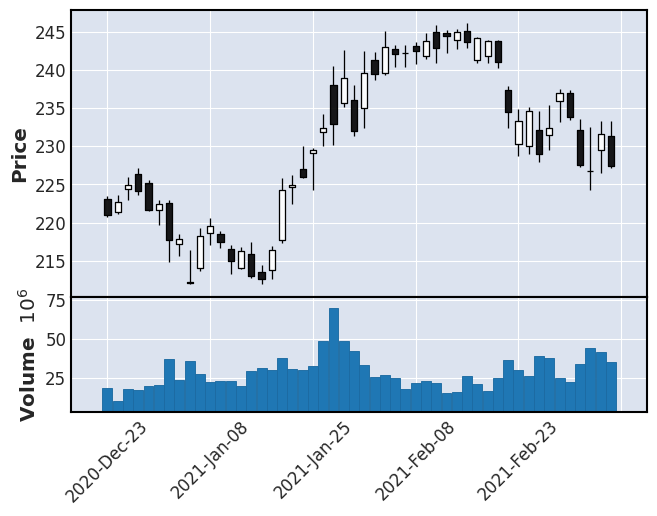

In [11]:
mpf.plot(df.iloc[-50:,:], type='candle', volume=True)

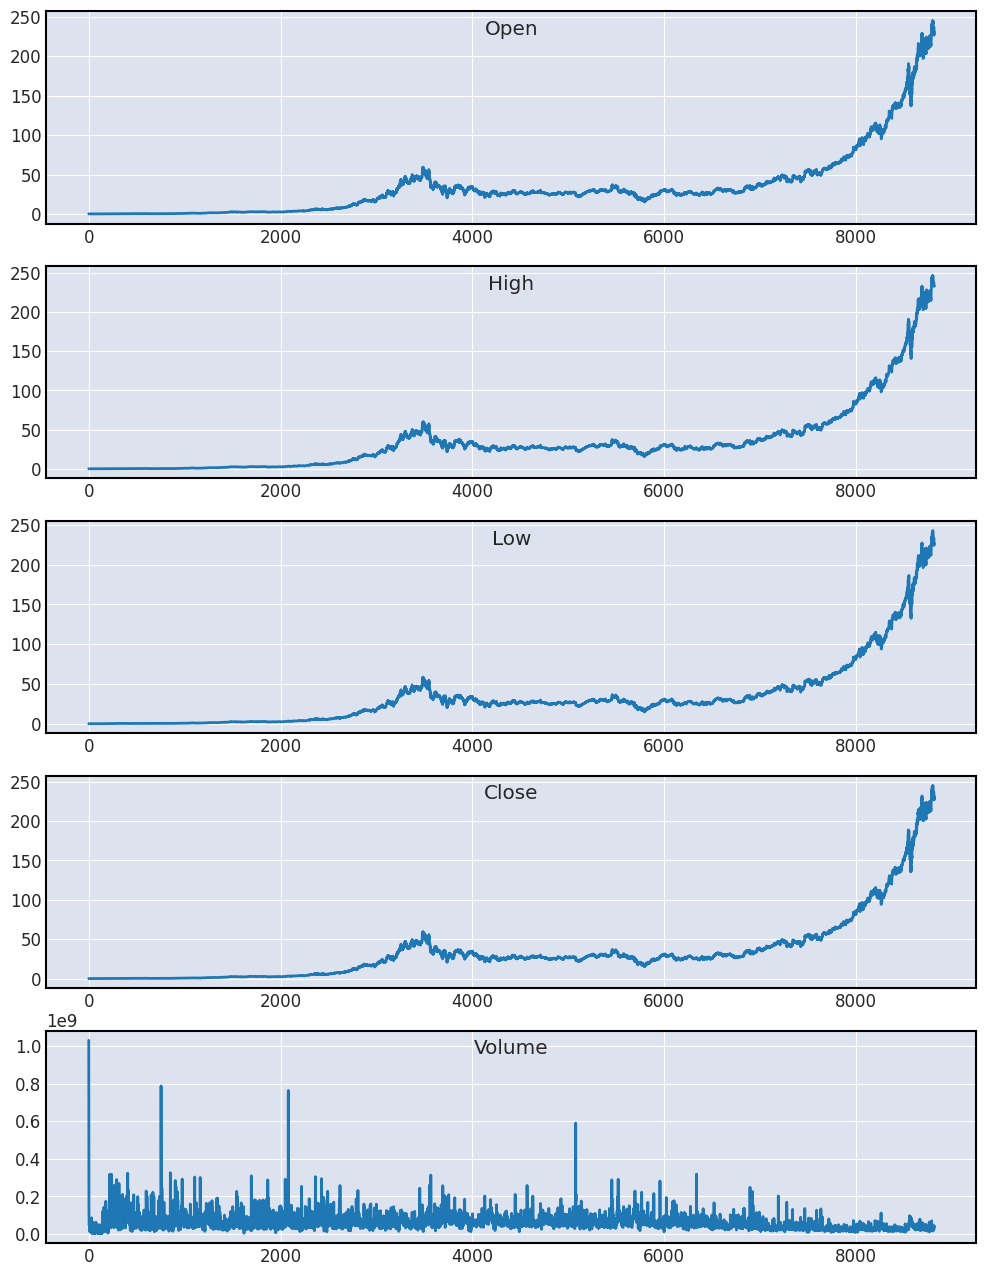

In [12]:
values = df.values

num_f = len(df.columns)

groups = [x for x in range(num_f)]

plt.figure(figsize = (12,16))

i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.85, loc='center')
    i += 1
plt.show()

In [13]:
def series_to_supervised(data, c_names, n_in=1, n_out=1, dropnan=True):
    '''
    This function reformats the dataset the way it can be fed to the LSTM.
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
   
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):

        cols.append(df.shift(i))
        names += ['%s(t-%d)' % (n, i) for n in c_names]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % n) for n in c_names]
        else:
            names += [('%s(t+%d)' % (n, i)) for n in c_names]
   
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [15]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_days_back = 240
n_days_future = 1
n_features = num_f

# frame as supervised learning
reframed = series_to_supervised(scaled, c_names, n_days_back, n_days_future)

print(reframed.head(5))

     Open(t-240)  High(t-240)  Low(t-240)  Close(t-240)  Volume(t-240)  \
240     0.000000     0.000039    0.000000      0.000028       1.000000   
241     0.000035     0.000042    0.000036      0.000043       0.297096   
242     0.000050     0.000046    0.000050      0.000050       0.127119   
243     0.000057     0.000046    0.000043      0.000039       0.063588   
244     0.000046     0.000035    0.000036      0.000032       0.044285   

     Open(t-239)  High(t-239)  Low(t-239)  Close(t-239)  Volume(t-239)  ...  \
240     0.000035     0.000042    0.000036      0.000043       0.297096  ...   
241     0.000050     0.000046    0.000050      0.000050       0.127119  ...   
242     0.000057     0.000046    0.000043      0.000039       0.063588  ...   
243     0.000046     0.000035    0.000036      0.000032       0.044285  ...   
244     0.000039     0.000025    0.000025      0.000021       0.054524  ...   

     Open(t-1)  High(t-1)  Low(t-1)  Close(t-1)  Volume(t-1)   Open(t)  \
240   

In [16]:
n_obs = n_days_back * n_features

target_idx = [reframed.columns.to_list().index(col) for col in reframed.columns[n_obs:] if 'Open' in col]


# split into train and test sets
values = reframed.values

n_train_days = 2000

train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [17]:
train_X, train_y = train[:, :n_obs], train[:, target_idx]
test_X, test_y = test[:, :n_obs], test[:, target_idx]

# reshape input to fit the LSTM network requirements: [n_samples, window, n_features]
train_X = train_X.reshape((train_X.shape[0], n_days_back, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days_back, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2000, 240, 5) (2000, 1) (6578, 240, 5) (6578, 1)


In [18]:
# design network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))

checkpoint = ModelCheckpoint('w.hdf5', monitor='val_loss', save_best_only=True)

callback_list = [checkpoint]

model.compile(optimizer = 'adam', loss = root_mean_squared_error)

t = model.fit(train_X, train_y, epochs=1000,
              batch_size=240,
              validation_data=(test_X, test_y),
              verbose=0,
              callbacks = callback_list,
              shuffle=False)

model.load_weights('w.hdf5')

[2021-03-10 04:38:58.222 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:13687 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-03-10 04:38:58.247 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:13687 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


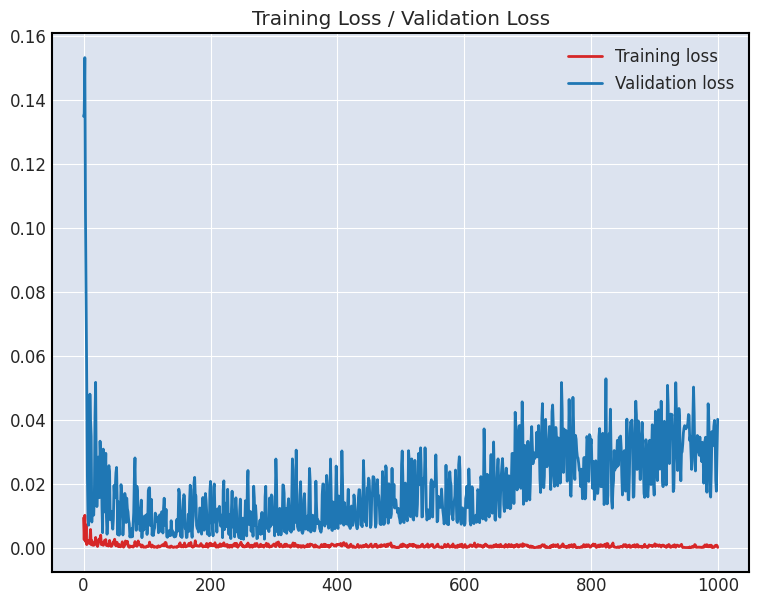

In [19]:
# plot training history
plt.figure(figsize = (9,7))
plt.title('Training Loss / Validation Loss')
plt.plot(t.history['loss'], 'tab:red', label='Training loss')
plt.plot(t.history['val_loss'], 'tab:blue', label='Validation loss')
plt.legend()
plt.show()

In [20]:
# make a prediction
yhat = model.predict(test_X)

# invert scaling
yhat_inv = yhat / scaler.scale_[0]
y_inv = test_y / scaler.scale_[0]

# reshape back
yhat_inv_rshp = yhat_inv.reshape((-1,1))
y_inv_rshp = y_inv.reshape((-1,1))

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_inv_rshp, yhat_inv_rshp))
print('Test set RMSE: %.2f' % rmse)

Test set RMSE: 1.04


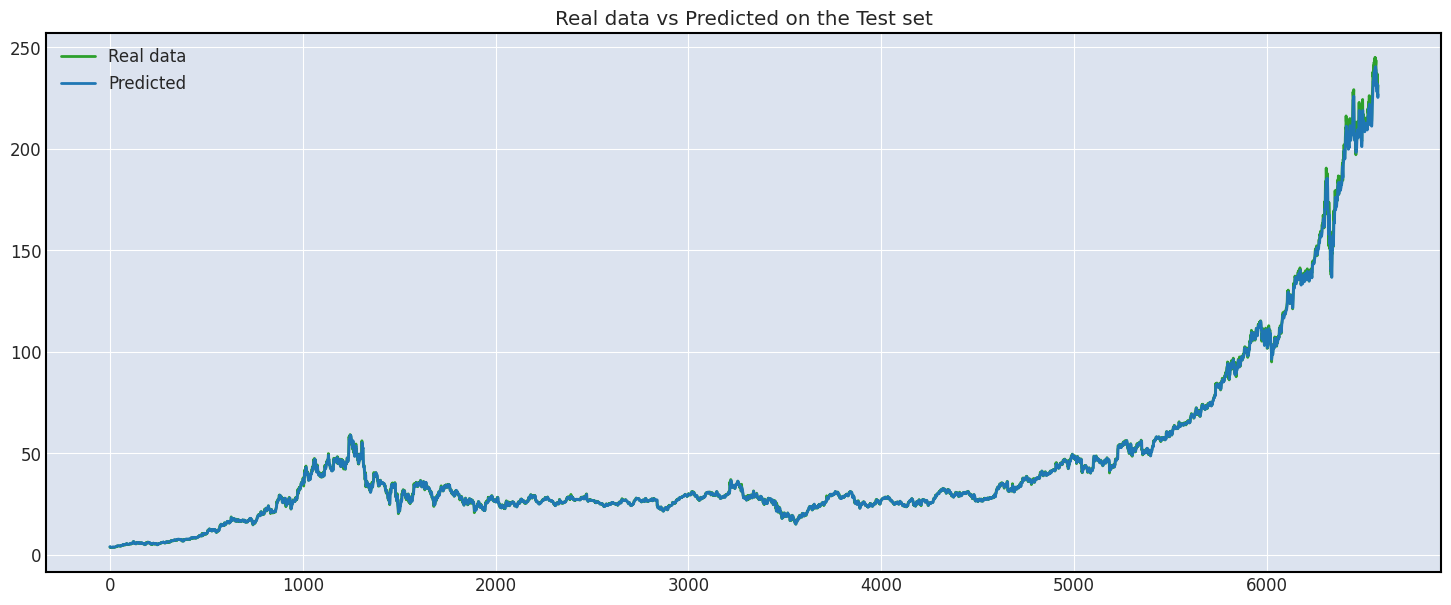

In [21]:
plt.figure(figsize = (18,7))
plt.title('Real data vs Predicted on the Test set')
plt.plot(y_inv_rshp, 'tab:green', label='Real data')
plt.plot(yhat_inv_rshp, 'tab:blue', label='Predicted')
plt.legend()
plt.show()

In [22]:
print(f'Initial set size: {df.shape[0]}')
print(f'Train set X size: {train_X.shape[0]}, train set y size: {train_y.shape[0]}')
print(f'Test set X size: {test_X.shape[0]}, test set y size: {test_y.shape[0]}')

Initial set size: 8818
Train set X size: 2000, train set y size: 2000
Test set X size: 6578, test set y size: 6578


In [23]:
reframed.tail(1)

,Open(t-240),High(t-240),Low(t-240),Close(t-240),Volume(t-240),Open(t-239),High(t-239),Low(t-239),Close(t-239),Volume(t-239),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
8817,0.586513,0.607662,0.581397,0.605349,0.077915,0.60758,0.626887,0.594451,0.59955,0.071234,...,0.936679,0.947732,0.932216,0.945325,0.038406,0.944232,0.948138,0.934976,0.928134,0.031998


In [24]:
last_day = reframed.iloc[-1:, -n_obs:]
last_day = last_day.values
last_day = last_day.reshape((-1, n_days_back, n_features))

t_plus_one = model.predict(last_day)
t_plus_one /= scaler.scale_[0]

print("SYMBOl ---> ", symbol)
print('Last observation\'s date in the dateset is %s\nLast observation\'s value is %.2f' % (df.index[-1].date(), df.iloc[-1, 0]))
print('\nPredicted observation\'s date is %s\nPredicted observation\'s value is %.2f' % (df.index[-1].date() + datetime.timedelta(days=1), t_plus_one))
# print('\nReal value for %s is %.2f' % (df.index[-1].date() + datetime.timedelta(days=1), yf.Ticker(symbol).history(period='1d')['Close'][0]))

start = str((df.index[-1].date() + datetime.timedelta(days=-1)))
end = str((df.index[-1].date() + datetime.timedelta(days=5)))

latest_stock = yf.download(symbol, start=start, end=end, progress=False)

latest_stock.Close.head(5)


# print('\nReal value %s' % (latest_stock.Close[:1]))


      Open(t-239)  High(t-239)  Low(t-239)  Close(t-239)  Volume(t-239)  \
8817      0.60758     0.626887    0.594451       0.59955       0.071234   

      Open(t-238)  High(t-238)  Low(t-238)  Close(t-238)  Volume(t-238)  ...  \
8817     0.605498     0.636357    0.610635      0.637076       0.060481  ...   

      Open(t-1)  High(t-1)  Low(t-1)  Close(t-1)  Volume(t-1)   Open(t)  \
8817   0.936679   0.947732  0.932216    0.945325     0.038406  0.944232   

       High(t)    Low(t)  Close(t)  Volume(t)  
8817  0.948138  0.934976  0.928134   0.031998  

[1 rows x 1200 columns]
SYMBOl --->  MSFT
Last observation's date in the dateset is 2021-03-08
Last observation's value is 231.37

Predicted observation's date is 2021-03-09
Predicted observation's value is 226.62


Date
2021-03-08    227.389999
2021-03-09    233.779999
Name: Close, dtype: float64